In [1]:
import numpy as np
import cv2
from PIL import Image
import pytesseract
import matplotlib.image as img # 이미지 띄워주는 코드
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

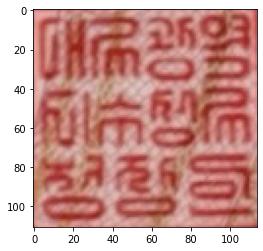

In [4]:
image = cv2.imread('C:\\DevRoot\\Dropbox\\Py27\\10_ComputerVision\\drive.jpg')
# 꼭 사진의 사각형이 선명하게 드러나야 함
def draw_vertices(image):
    
    r = 800.0 / image.shape[0]
    dim = (int(image.shape[1] * r), 800)
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    edged = cv2.Canny(gray, 75, 200)

    (cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        if len(approx) == 4:
            global screenCnt
            screenCnt = approx
            break

    rect = order_points(screenCnt.reshape(4, 2))
    (topLeft, topRight, bottomRight, bottomLeft) = rect
    # print(rect)
    # 두개의 너비, 높이 계산
    w1 = abs(bottomRight[0] - bottomLeft[0])
    w2 = abs(topRight[0] - topLeft[0])
    h1 = abs(topRight[1] - bottomRight[1])
    h2 = abs(topLeft[1] - bottomLeft[1])

    # # 최대 너비와 최대 높이 계산
    maxWidth = max([w1, w2])
    maxHeight = max([h1, h2])

    # # 반환할 좌표의 위치 초기화
    dat = np.float32([[0, 0], [maxWidth-1, 0], [maxWidth-1, maxHeight-1], [0, maxHeight-1]])
    M = cv2.getPerspectiveTransform(rect, dat)
    warped = cv2.warpPerspective(image.copy(), M, (int(maxWidth), int(maxHeight)), flags=cv2.INTER_CUBIC)

    # # 이미지 띄우기
    cv2.imwrite('image3.jpg', warped)

    # 콘솔에 이미지 띄우기
    image1 = img.imread('image3.jpg')
    plt.imshow(image1)
    plt.show()

    
    # 텍스트 출력
    text = pytesseract.image_to_string('image3.jpg', lang='Hangul')
    print(text)
    
    return warped
    
    
# 꼭지점 자르기
def order_points(pta):
    rect = np.zeros((4, 2), dtype=np.float32)
    
    s = pta.sum(axis = 1)
    rect[0] = pta[np.argmin(s)]
    rect[2] = pta[np.argmax(s)]
    
    diff = np.diff(pta, axis = 1)
    rect[1] = pta[np.argmin(diff)]
    rect[3] = pta[np.argmax(diff)]
    
    return rect

# 이미지 호출
def auto_scan_image():
    image = cv2.imread('C:\\DevRoot\\Dropbox\\Py27\\10_ComputerVision\\min.jpg')
    
    image = draw_vertices(image) 

if __name__ == '__main__':
    auto_scan_image()



In [ ]:
# 노이즈 캔슬링
def noise_canceling(warped):
    
    # 잡음 제거
    warped = cv2.fastNlMeansDenoisingColored(warped, None, 10, 10, 7, 21)
    
    cv2.imwrite('image6.jpg', warped)
    image = img.imread('image6.jpg')
    plt.imshow(image)
    plt.show()
    
    text = pytesseract.image_to_string('image6.jpg', lang='Hangul')
    print(text)
    
    return warped
    
    
image3 = cv2.imread('image3.jpg')
image3 = noise_canceling(image3)

In [ ]:
# 반사광 제거
def remove_reflection(warped):
    hav_image = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hav_image)
    
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
    v = clahe.apply(v)
    
    hav_image = cv2.merge([h, s, v])
    hav_image = cv2.cvtColor(hav_image, cv2.COLOR_HSV2RGB)
    
    cv2.imwrite('image9.jpg', hav_image)
    
    image3 = img.imread('image9.jpg')
    plt.imshow(image3)
    plt.show()
    
    text = pytesseract.image_to_string('image9.jpg', lang='Hangul')
    print(text)
    
    return warped


image = cv2.imread('image3.jpg')
image = remove_reflection(image)
    

In [ ]:
# 노이즈 제거
def noise_removal(warped):
    warped = cv2.medianBlur(warped, ksize = 5)
    
    cv2.imwrite('image12.jpg', warped)
    
    image = img.imread('image12.jpg')
    plt.imshow(image)
    plt.show()

    text = pytesseract.image_to_string('image12.jpg', lang='Hangul')
    print(text)
    
    return warped

    
image12 = cv2.imread('image9.jpg')
image12 = noise_removal(image12)

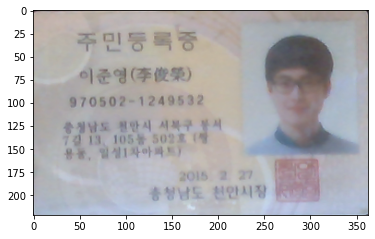

In [59]:
import sys, os
import cv2
import pytesseract
import csv
import numpy as np
import re
import matplotlib.pyplot as plt

def order_points(pta):
    rect = np.zeros((4, 2), dtype=np.float32)
    
    s = pta.sum(axis = 1)
    rect[0] = pta[np.argmin(s)]
    rect[2] = pta[np.argmax(s)]
    
    diff = np.diff(pta, axis = 1)
    rect[1] = pta[np.argmin(diff)]
    rect[3] = pta[np.argmax(diff)]
    
    return rect


# 카메라 오픈!
cap = cv2.VideoCapture(0)
delay_frame = []

if not cap.isOpened():
    print('Camera Open Fail!')

while True:
    # 한장 가져오기
    _, frame = cap.read()
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # threshold only 
    img_thresh = cv2.adaptiveThreshold(
        gray, # src 입력 영상 gray scale
        maxValue = 255.0, 
        adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C, # thresholding value 를 계산하는 방법
        thresholdType = cv2.THRESH_BINARY_INV,
        blockSize = 19,  # thresholding 을 적용할 영역 사이즈
        C = 9,  # 평균이나 가중 평균에 차감할 값

    )

    # blur and threshold
    img_blurred = cv2.GaussianBlur(gray, 
                                    ksize = (7,7), # kernel size. (0, 0) 을 지정하면 sigma 값에 의해 자동 결정
                                    sigmaX = 0, # x 방향 sigma
                                    )

    img_blur_thresh = cv2.adaptiveThreshold(
        img_blurred,
        maxValue = 255.0,
        adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType = cv2.THRESH_BINARY_INV,
        blockSize = 19,
        C = 9,
    )
    
    (cnts, _) = cv2.findContours(img_blur_thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        if len(approx) == 4:
            global screenCnt
            screenCnt = approx
            break
    
    
    rect = order_points(screenCnt.reshape(4, 2))
    (topLeft, topRight, bottomRight, bottomLeft) = rect
    # print(rect)
    # 두개의 너비, 높이 계산
    w1 = abs(bottomRight[0] - bottomLeft[0])
    w2 = abs(topRight[0] - topLeft[0])
    h1 = abs(topRight[1] - bottomRight[1])
    h2 = abs(topLeft[1] - bottomLeft[1])
    
    # # 최대 너비와 최대 높이 계산
    maxWidth = max([w1, w2])
    maxHeight = max([h1, h2])
    
    if w1 > 300 and w2 > 300 and(h1 > 200 or h2 > 200):
        if maxWidth * maxHeight > 60000:
            
            # 반환할 좌표의 위치 초기화
            dat = np.float32([[0, 0], [maxWidth-1, 0], [maxWidth-1, maxHeight-1], [0, maxHeight-1]])
            M = cv2.getPerspectiveTransform(rect, dat)  
            warped = cv2.warpPerspective(frame, M, (int(maxWidth), int(maxHeight)), flags=cv2.INTER_CUBIC)    
            delay_frame.append(warped)
            
    # 이미지를 기다렸다가 뽑는다.
    if len(delay_frame) > 20:
        break
            

    if frame is None:
        print('읽어오기 실패')
            

    # 해당 이미지가 나왔으면 종료

      
    if cv2.waitKey(1) == 27: # ESC 눌려야 빠져 나옴
        break
        
    cv2.rectangle(frame, (110, 130), (540, 400), (0, 255, 0))   
    cv2.imshow('frame', frame)
    
    
        
cap.release()
cv2.destroyAllWindows()
conv_img = cv2.cvtColor(delay_frame[-1], cv2.COLOR_BGR2RGB)
plt.imshow(conv_img)



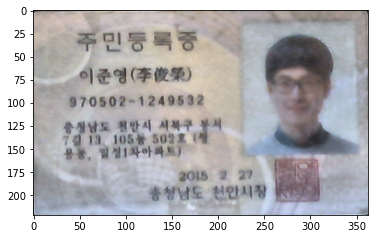

In [66]:
#노이즈 캔슬링
# warped = cv2.fastNlMeansDenoisingColored(delay_frame[-1], None, 10, 10, 7, 21)

#반사광
warped = cv2.cvtColor(delay_frame[-1], cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(warped)
    
clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
v = clahe.apply(v)

warped = cv2.merge([h, s, v])
warped = cv2.cvtColor(warped, cv2.COLOR_HSV2RGB)
dst_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
plt.imshow(dst_rgb)

In [67]:
def vision2(img, form):

    #json 부르고
    form2 = form

    #노이즈 캔슬링
#     warped = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

    #반사광
    warped = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(warped)
    
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
    v = clahe.apply(v)
    
    warped = cv2.merge([h, s, v])
    warped = cv2.cvtColor(warped, cv2.COLOR_HSV2RGB)
    dst_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
    if form2 == 0:
        text = pytesseract.image_to_string(dst_rgb, lang='hangul')
        print(text)
        text = re.sub('[=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》¢]','', text)
        text = text.replace(' ', '')
        f = text.split('\n')
        f = [i for i in f if i] 
        final = [['성명', f[2][0:int(len(f[2])/2)]], ['주민등록번호', f[3]], ['주소', f[4]+f[5]+f[6]], ['발급일', f[7]]]
    else:
        text = pytesseract.image_to_string(dst_rgb, lang='hangul+eng')
        text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》¢]','', text)
        pnum = re.search('([a-zA-Z]{1}|[a-zA-Z]{2})\d{8}', text).group()
        text = text.replace(' ', '')
        f = text.split('\n')
        f = [i for i in f if i]
            
        final = [['여권번호', pnum], ['성', f[3]], ['이름', f[5]], ['생년월일', f[9][0:9]], ['주민등록번호', f[9][9:]], ['성별', f[11]], ['발급일', f[13][0:9]], ['기간만료일', f[15][0:9]]]
    
    with open('id1.csv', 'w', encoding='euc-kr', newline='') as f:
        writer = csv.writer(f)
        #한줄 넣는다
        writer.writerows(final)
        
vision2(delay_frame[-1], 0)


쿠 민 동 록 롱 “| 걸 |
이 준 영 ( 주 %) v
970502-1249502 '
a 썼 한 시 서 북 추 2 !
19. 105% 5028
기 $

1m
옹진 UE 선 안 시 장



In [1]:
# -*- coding: utf-8 -*-
import sys, os
import cv2
import pytesseract
import csv
import numpy as np
import re

def order_points(pta):
    rect = np.zeros((4, 2), dtype=np.float32)
    
    s = pta.sum(axis = 1)
    rect[0] = pta[np.argmin(s)]
    rect[2] = pta[np.argmax(s)]
    
    diff = np.diff(pta, axis = 1)
    rect[1] = pta[np.argmin(diff)]
    rect[3] = pta[np.argmax(diff)]
    
    return rect

#import할거는 여기있는거 지우고 다 views에 넣을 계획
#원래는 파라미터에 img를 넣을 계획인데 현재는 cmd에서 테스트 하고있어서 뺏다
#사진, (민증 0, 여권 1)
def vision2(img, form):

    #json 부르고
    form2 = form
    src = cv2.imread(img)

    #노이즈 캔슬링
    warped = cv2.fastNlMeansDenoisingColored(warped, None, 10, 10, 7, 21)

    #반사광
    warped = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(warped)
    
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
    v = clahe.apply(v)
    
    warped = cv2.merge([h, s, v])
    warped = cv2.cvtColor(warped, cv2.COLOR_HSV2RGB)
    dst_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
    if form2 == 0:
        text = pytesseract.image_to_string(dst_rgb, lang='hangul')
        text = re.sub('[=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》¢]','', text)
        text = text.replace(' ', '')
        f = text.split('\n')
        f = [i for i in f if i] 
        final = [['성명', f[2][0:int(len(f[2])/2)]], ['주민등록번호', f[3]], ['주소', f[4]+f[5]+f[6]], ['발급일', f[7]]]
    else:
        text = pytesseract.image_to_string(dst_rgb, lang='hangul+eng')
        text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》¢]','', text)
        pnum = re.search('([a-zA-Z]{1}|[a-zA-Z]{2})\d{8}', text).group()
        text = text.replace(' ', '')
        f = text.split('\n')
        f = [i for i in f if i]
            
        final = [['여권번호', pnum], ['성', f[3]], ['이름', f[5]], ['생년월일', f[9][0:9]], ['주민등록번호', f[9][9:]], ['성별', f[11]], ['발급일', f[13][0:9]], ['기간만료일', f[15][0:9]]]
    
    with open('id1.csv', 'w', encoding='euc-kr', newline='') as f:
        writer = csv.writer(f)
        #한줄 넣는다
        writer.writerows(final)

IndexError: list index out of range